In [ ]:
# Install FEniCS
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install-real.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin

# Governing Equations of Fluid Flow

The Navier-Stokes equations are partial differential equations which describe the motion of viscous fluid.

Following fundamental laws can be used to derive governing differential equations that are solved in
a Computational Fluid Dynamics (CFD) study:
* conservation of mass: (A continuity equation or transport equation is an equation that describes the transport of some quantity.)
* conservation of momentum (Newton's second law)

All fluids are compressible to some degree, but their flow can be approximated as incompressible (i.e. pressure changes due to flow don't cause significant density changes).

**PDE problem**

The incompressible Navier-Stokes equations form a system of equations for the velocity $u$ and pressure $p$ in an incompressible fluid:


\begin{align}
  \text{Momentum equation:}\\
  \varrho\left(\frac{\partial u}{\partial t} +
  u \cdot \nabla u\right) &= \nabla\cdot\sigma(u, p) + f, \\
  \text{Continuity equation:}\\
  \nabla \cdot u &= 0.
\end{align}

The right-hand side $f$ is a given force per unit volume and just as for the equations of linear elasticity, $\sigma(u, p)$ denotes the stress tensor, which for a Newtonian fluid is given by

* Stress tensor:
\begin{equation}
  \sigma(u, p) = 2\mu\epsilon(u) - pI,
\end{equation}
where $\epsilon(u)$ is the strain-rate tensor

* Strain-rate tensor:

$$ \epsilon(u) = \frac{1}{2}\left(\nabla u + (\nabla u)^T\right).$$
The parameter $\mu$ is the dynamic viscosity. Note that the momentum equation is very similar to the elasticity equation. The difference is in the
two additional terms $\varrho(\partial u / \partial t + u \cdot \nabla u)$ and the different expression for the stress tensor. The two extra terms express the
acceleration balanced by the force $F = \nabla\cdot\sigma + f$ per unit volume in Newton's second law of motion.

This problem combines 3 problems: time-dependence, nonlinearity, and vector-valued variables.

# Stokes equations
Stokes Equations are a mathematical model to describe the behaviour of steady state flow of fluids.

## Strong form of the Stokes equations

The incompressible Stokes equations in strong form read: for a domain
$\Omega \subset \mathbb{R}^n$, find the velocity $\boldsymbol{u}$ and
the pressure $p$ satisfying

\begin{alignat}{2}
-\nabla\cdot\sigma(u, p) &= f \quad && \text{in } \Omega \\
\nabla\cdot u &= 0 \quad && \text{in } \Omega
\end{alignat}


where $\sigma(u) = 2\mu\varepsilon(u) - pI$ is the viscous stress tensor, $\varepsilon(u) = \frac{1}{2}(\nabla u + (\nabla u)^{\top})$ is the strain tensor (symmetric gradient), $I$ is the identity matrix and $\mu$ is the dynamic viscosity.

A typical set of boundary conditions on the boundary $\partial
\Omega = \Gamma_{D} \cup \Gamma_{N}$ can be:

\begin{align}
              \boldsymbol{u} &= \boldsymbol{u}_0 \ \ \ \ {\rm on} \ \Gamma_{D}, \\
      \sigma n  &= \boldsymbol{g}   \ \ \ \ \ \   {\rm on} \ \Gamma_{N}. \\
\end{align}

## Defining the variational problem
The finite element variational problem for the Stokes problem reads: Find $(u, p) \in W$ such that
$$
\int_{\Omega} \sigma(u) : \varepsilon(v) \,\mathrm{d}x - \int_{\partial \Omega} \sigma n \cdot v \mathrm{d}s
+
\int_{\Omega} \nabla \cdot u \, q \,\mathrm{d}x
=
\int_{\Omega} f \cdot v \,\mathrm{d}x
$$
for all $(v, q) \in W$. Note that the boundary traction terms vanish as a result of setting Dirichlet boundary conditions on $\Gamma_{D}$ (and thus $v = 0$), and by having $\sigma\cdot n = g$ on the outflow boundary $\Gamma_{N}$.

This can be expressed in FEniCS by defining the *bilinear form* $a$ and the *linear form* $L$:

\begin{align}
  a(u, v) &= \int_{\Omega} \sigma(u) : \varepsilon(v) \,\mathrm{d}x +
\int_{\Omega} \nabla \cdot u \, q \,\mathrm{d}x , \\
  L(v) &= \int_{\Omega} f \cdot v \,\mathrm{d}x + \int_{\Gamma_N} g \cdot v \mathrm{d}s.
\end{align}

where $\sigma(u) = 2\mu\varepsilon(u) - pI$ and $\varepsilon(u) = \frac{1}{2}(\nabla u + (\nabla u)^{\top})$.


## Implementation: Flow past a cylinder

The geometry and parameters are shown in the following figure.

The kinematic viscosity is given by $\nu = 0.001$ and the inflow velocity profile is specified as:

$$
u(x, y, t) = \left(1.5 \cdot \frac{4y(0.41 - y)}{0.41^2}, 0\right).
$$
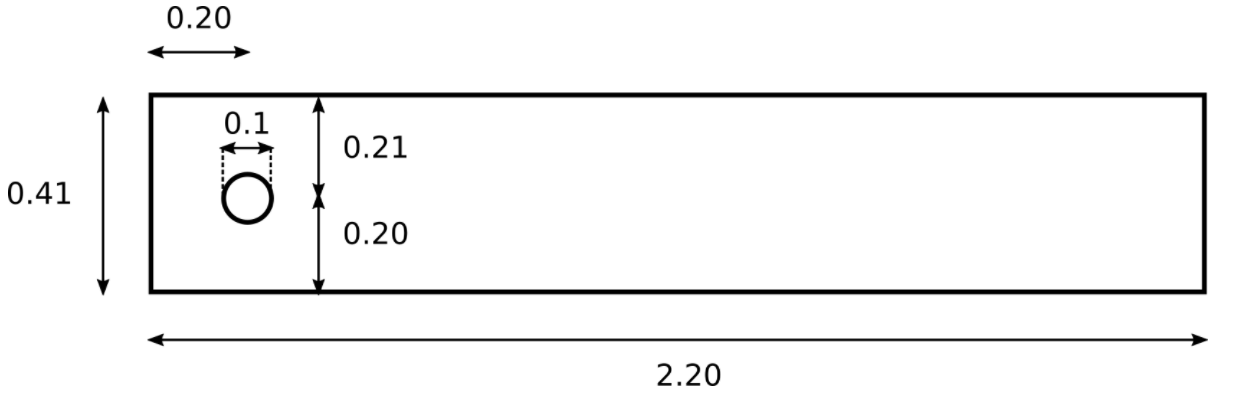

In [ ]:
from dolfin import *
from mshr import *
import matplotlib.pyplot as plt


# Problem data
u_in = Expression(("4.0*U*x[1]*(0.41 - x[1])/(0.41*0.41)", "0.0"),degree=2, U=1.5)
p_L = Constant(0)
#u_in = Expression(('-sin(pi*x[1])', '0.0'), degree=2)
mu = Constant(0.001)

## Creating the mesh

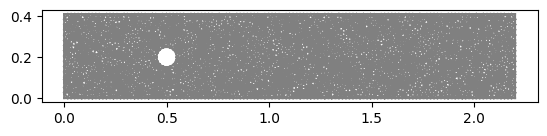

In [ ]:
# Discretization parameters
N_circle = 16
N_bulk = 64


# Define domain
center = Point(0.5, 0.2)
radius = 0.05
L = 2.2
Wd = 0.41
geometry = Rectangle(Point(0.0, 0.0), Point(L, Wd)) - Circle(center, radius, N_circle)

# Build mesh
mesh = generate_mesh(geometry, N_bulk)
plot(mesh)

## Defining the finite element function space

When we have created the mesh, we can define the finite element function space. Since we will be solving a system of equations, we need to create a *mixed* finite element which combines a vector finite element $V$ for the velocity and scalar finite element $Q$ for the pressure.

In [ ]:
# Define function spaces (Taylor-Hood)
P2 = VectorElement('CG', triangle, 2)  # Velocity --> degree = 2
P1 = FiniteElement('CG', triangle, 1)  # Pressure --> degree = 1
TH = MixedElement([P2, P1])
W = FunctionSpace(mesh, TH)

## Defining the boundary conditions

Since we have a system of equations and want to specify boundary conditions for both components, we must use `W.sub(0)` and `W.sub(1)` to access the two components of the function space corresponding to `u` and `p` in the definition of the boundary conditions.

In [ ]:
# Construct boundaries
bndry = MeshFunction("size_t", mesh, mesh.topology().dim()-1)

# define boundaries for the subdomain
# walls
class Walls(SubDomain):
  def inside(self, x, on_boundary):
    tol = 1E-14
    return (on_boundary and abs(x[1]) < tol) or (on_boundary and abs(x[1]- Wd) < tol)

walls = Walls()

# inflow
class Inflow(SubDomain):
  def inside(self, x, on_boundary):
    tol = 1E-14
    return on_boundary and abs(x[0]) < tol

inflow = Inflow()

# outflow
class Outflow(SubDomain):
    def inside(self, x, on_boundary):
        tol = 1E-14
        return on_boundary and abs(x[0]- L) < tol
outflow = Outflow()

# cylinder
class Cylinder(SubDomain):
    def inside(self, x, on_boundary):
        tol = 1E-14
        return on_boundary and abs((x[0]- 0.5)**2 + (x[1]- 0.2)**2 - radius**2) < tol
cylinder = Cylinder()


bndry.set_all(0)

inflow.mark(bndry, 1)
outflow.mark(bndry, 2)
walls.mark(bndry, 3)
cylinder.mark(bndry, 5)


# Define the integration on boundary
ds = Measure("ds", domain=mesh, subdomain_data=bndry)


# Dirichlet boundary conditions
#  No-slip boundary
bc_walls = DirichletBC(W.sub(0), (0, 0), bndry, 3)
bc_cylinder = DirichletBC(W.sub(0), (0, 0), bndry, 5)
# The inflow velocity
bc_in = DirichletBC(W.sub(0), u_in, bndry, 1)
# The outflow pressure
bc_out = DirichletBC(W.sub(1), p_L, bndry, 2)

bcs = [bc_cylinder, bc_walls, bc_in, bc_out]

## Defining the variational problem

In [ ]:
# Solve steady Stokes
d = 2

def epsilon(u):
    return sym(grad(u))

def sigma(u, p):
    return 2*mu*epsilon(u) - p*Identity(d)


# Define variational forms
u, p = TrialFunctions(W)
v, q = TestFunctions(W)
a = inner(sigma(u,p), epsilon(v))*dx + div(u)*q*dx
L = dot(Constant((0, 0)), v)*dx + dot(Constant((0, 0)), v)*ds

## Solving the variational problem



In [ ]:
# Solve the problem
w = Function(W)
solve(a == L, w, bcs)

## Plotting the velocity  and pressure

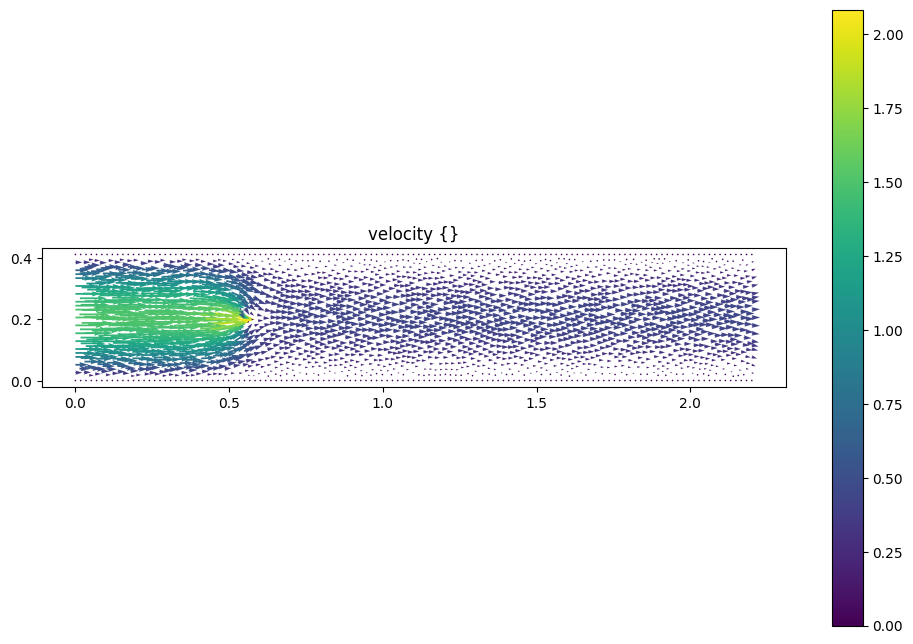

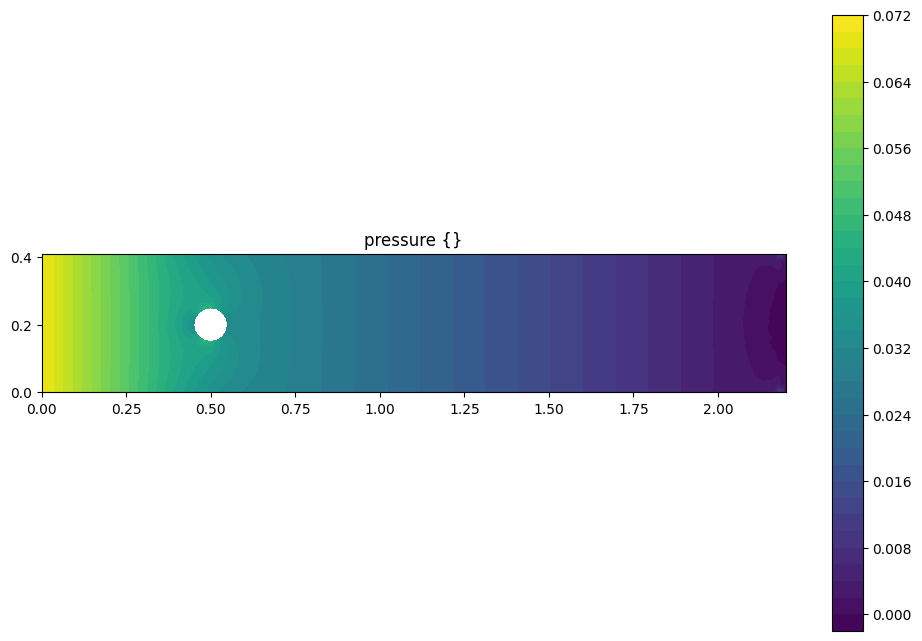

In [ ]:
u, p = w.split()
# Plot
plt.figure(figsize=(12,8))
pl = plot(u, title='velocity {}')
plt.colorbar(pl)
plt.figure(figsize=(12,8))
pl = plot(p, title='pressure {}')
plt.colorbar(pl)

## Postprocessing
To postprocess the solution using an external postprocessor, for example Paraview, save the solution to VTK format (file suffix `.pvd`).

In [ ]:
File('velocity.pvd') << u
File('pressure.pvd') << p

## Exercice:

Solve the Stokes equations with FEniCS:

\begin{alignat}{2}
-\nabla\cdot\sigma(u, p) &= f \quad && \text{in } \Omega \\
\nabla\cdot u &= 0 \quad && \text{in } \Omega \\
u &= u_{\mathrm{R}} \quad && \text{on } \Gamma_{\mathrm{R}} \\
\sigma\cdot n &= (0, 0) \quad && \text {on } \Gamma_{\mathrm{L}} \\
p &= p_{\mathrm{L}} \quad && \text {on } \Gamma_{\mathrm{L}} \\
u &= (0,0) \quad && \text{on } \Gamma_0 \\
\end{alignat}

where $\sigma(u) = 2\mu\varepsilon(u) - pI$ is the viscous stress tensor, $\varepsilon(u) = \frac{1}{2}(\nabla u + (\nabla u)^{\top})$ is the strain tensor (symmetric gradient) and $I$ is the identity matrix.

This is a model of linear (creeping) flow in the idealized case of infinitesimal (small) velocities.

We will use the following data:

* $\Omega$ defined by the mesh `dolfin_coarse.xml`

From: https://fenicsproject.org/pub/data/meshes/dolfin_coarse.xml

* $f = (0,0)$
* $\Gamma_{\mathrm{L}} = \{(x,y,z) \in \partial\Omega \,\vert\, x = 0\}$ (the left boundary)
* $\Gamma_{\mathrm{R}} = \{(x,y,z) \in \partial\Omega \,\vert\, x = 1\}$ (the right boundary)
* $\Gamma_{0} = \partial\Omega \setminus (\Gamma_{\mathrm{L}} \cup \Gamma_{\mathrm{R}})$ (no-slip boundary condition)
* $p_{\mathrm{L}} = 0$ (outflow)
* $u_{\mathrm{R}} = (-\sin(\pi y), 0)$ (inflow)
* $\mu = 1$ (dynamic viscosity)


In [ ]:
import requests


url = 'https://fenicsproject.org/pub/data/meshes/dolfin_coarse.xml.gz'
r = requests.get(url, allow_redirects=True)

open('dolfin_coarse.xml.gz', 'wb').write(r.content)

20702

In [ ]:
!ls

dolfin_coarse.xml.gz  pressure.pvd  velocity000000.vtu
pressure000000.vtu    sample_data   velocity.pvd


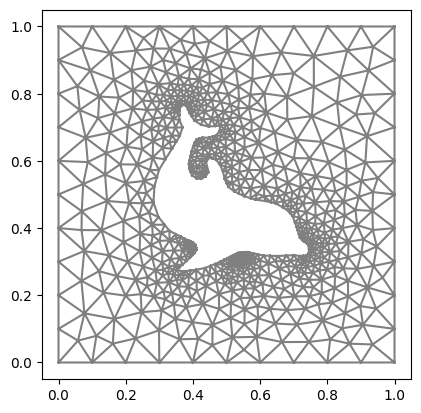

In [ ]:
from dolfin import *
from mshr import *
import matplotlib.pyplot as plt

mesh = Mesh('dolfin_coarse.xml.gz')
plot(mesh)

# To Construct dolphin boundary
```
def dolphin(x, on_boundary):
  return on_boundary and not any(b(x, on_boundary) for b in [left, right, bottom, top])
```

In [ ]:
# Problem data
#u_in = Expression(("4.0*U*x[1]*(0.41 - x[1])/(0.41*0.41)", "0.0"),degree=2, U=1.5)
p_L = Constant(0)
u_in = Expression(('-sin(pi*x[1])', '0.0'), degree=2)
mu = Constant(1.0)

In [ ]:
# Define function spaces (Taylor-Hood)
P2 = VectorElement('CG', triangle, 2)  # Velocity --> degree = 2
P1 = FiniteElement('CG', triangle, 1)  # Pressure --> degree = 1
TH = MixedElement([P2, P1])
W = FunctionSpace(mesh, TH)

In [ ]:
# Construct boundaries
bndry = MeshFunction("size_t", mesh, mesh.topology().dim()-1)

# define boundaries for the subdomain
# walls
def Left( x, on_boundary):
      tol = 1E-14
      return (on_boundary and abs(x[0]) < tol)

def Right( x, on_boundary):
      tol = 1E-14
      return (on_boundary and abs(x[0] - 1) < tol)

def Top( x, on_boundary):
      tol = 1E-14
      return (on_boundary and abs(x[1] - 1) < tol)

def Bottom( x, on_boundary):
      tol = 1E-14
      return (on_boundary and abs(x[1]) < tol)


# inflow
def inflow( x, on_boundary):
    tol = 1E-14
    return on_boundary and abs(x[0]) < tol


# outflow
def Outflow( x, on_boundary):
        tol = 1E-14
        return on_boundary and abs(x[0]- 1) < tol

# dolphain
def Dolphain( x, on_boundary):
      tol = 1E-14
      return on_boundary and not any(b(x, on_boundary) for b in [Left, Right, Bottom, Top])


# Define the integration on boundary
ds = Measure("ds", domain=mesh, subdomain_data=bndry)


# Dirichlet boundary conditions
#  No-slip boundary
bc1 = DirichletBC(W.sub(0), (0,0), Top)
bc2 = DirichletBC(W.sub(0), (0,0), Bottom)
bc3 = DirichletBC(W.sub(0), (0,0), Left)
bc4 = DirichletBC(W.sub(0), (0,0), Right)
bc5 = DirichletBC(W.sub(0), u_in, inflow)
bc6 = DirichletBC(W.sub(1), p_L, Outflow)
bc7 = DirichletBC(W.sub(0), (0,0), Dolphain)

bcs = [bc1, bc2, bc3, bc4, bc5, bc6, bc7]

In [ ]:
# Solve steady Stokes
d = 2

def epsilon(u):
    return sym(grad(u))

def sigma(u, p):
    return 2*mu*epsilon(u) - p*Identity(d)


# Define variational forms
u, p = TrialFunctions(W)
v, q = TestFunctions(W)
a = inner(sigma(u,p), epsilon(v))*dx + div(u)*q*dx
L = dot(Constant((0, 0)), v)*dx + dot(Constant((0, 0)), v)*ds

In [ ]:
# Solve the problem
w = Function(W)
solve(a == L, w, bcs)

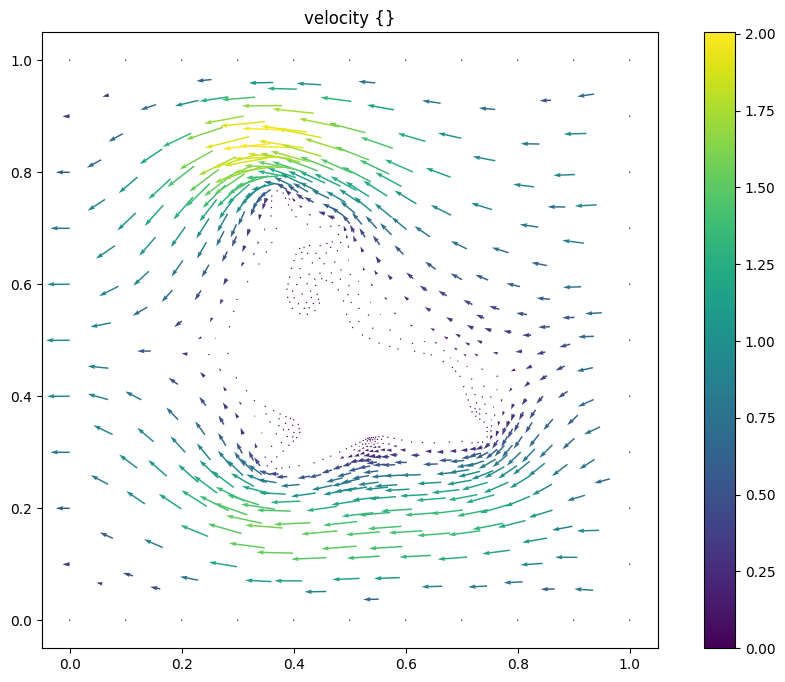

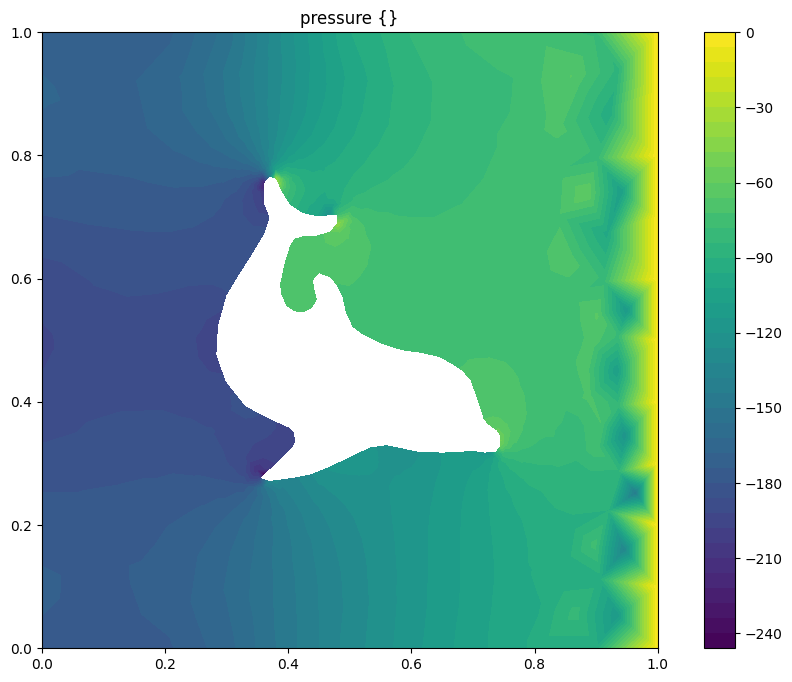

In [ ]:
u, p = w.split()
# Plot
plt.figure(figsize=(12,8))
pl = plot(u, title='velocity {}')
plt.colorbar(pl)
plt.figure(figsize=(12,8))
pl = plot(p, title='pressure {}')
plt.colorbar(pl)

In [ ]:
from dolfin import *
from mshr import *
import matplotlib.pyplot as plt


# Problem data
u_in = Constant((5.0, 0.0))
p_L = Constant(0)
#u_in = Expression(('-sin(pi*x[1])', '0.0'), degree=2)
mu = Constant(1)

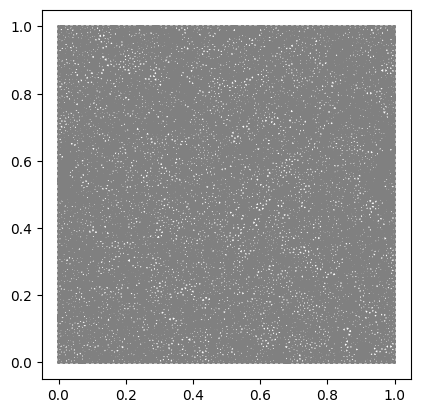

In [ ]:
# Discretization parameters
N_circle = 16
N_bulk = 64


# Define domain
L = 1
Wd = 1
geometry = Rectangle(Point(0.0, 0.0), Point(L, Wd))

# Build mesh
mesh = generate_mesh(geometry, N_bulk)
plot(mesh)

In [ ]:
# Define function spaces (Taylor-Hood)
P2 = VectorElement('CG', triangle, 2)  # Velocity --> degree = 2
P1 = FiniteElement('CG', triangle, 1)  # Pressure --> degree = 1
TH = MixedElement([P2, P1])
W = FunctionSpace(mesh, TH)

In [ ]:
# define boundaries for the subdomain
# walls
def Left( x, on_boundary):
      tol = 1E-14
      return (on_boundary and abs(x[0]) < tol)

def Right( x, on_boundary):
      tol = 1E-14
      return (on_boundary and abs(x[0] - 1) < tol)

def Top( x, on_boundary):
      tol = 1E-14
      return (on_boundary and abs(x[1] - 1) < tol)

def Bottom( x, on_boundary):
      tol = 1E-14
      return (on_boundary and abs(x[1]) < tol)



# Define the integration on boundary
ds = Measure("ds", domain=mesh, subdomain_data=bndry)


# Dirichlet boundary conditions
#  No-slip boundary
bc1 = DirichletBC(W.sub(0), (5,0), Top)
bc2 = DirichletBC(W.sub(0), (0,1), Bottom)
bc3 = DirichletBC(W.sub(0), (0,0), Left)
bc4 = DirichletBC(W.sub(0), (0,0), Right)


bcs = [bc1, bc2, bc3, bc4]

In [ ]:
# Solve steady Stokes
d = 2

def epsilon(u):
    return sym(grad(u))

def sigma(u, p):
    return 2*mu*epsilon(u) - p*Identity(d)


# Define variational forms
u, p = TrialFunctions(W)
v, q = TestFunctions(W)
a = inner(sigma(u,p), epsilon(v))*dx + div(u)*q*dx
L = dot(Constant((0, 0)), v)*dx + dot(Constant((0, 0)), v)*ds

In [ ]:
# Solve the problem
w = Function(W)
solve(a == L, w, bcs)

RuntimeError: 

*** -------------------------------------------------------------------------
*** DOLFIN encountered an error. If you are not able to resolve this issue
*** using the information listed below, you can ask for help at
***
***     https://fenicsproject.discourse.group/
***
*** Remember to include the error message listed below and, if possible,
*** include a *minimal* running example to reproduce the error.
***
*** -------------------------------------------------------------------------
*** Error:   Unable to extract mesh from form.
*** Reason:  Non-matching meshes for function spaces and/or measures.
*** Where:   This error was encountered inside Form.cpp.
*** Process: 0
*** 
*** DOLFIN version: 2019.2.0.dev0
*** Git changeset:  1c52e837eb54cc34627f90bde254be4aa8a2ae17
*** -------------------------------------------------------------------------


In [ ]:
u, p = w.split()
# Plot
plt.figure(figsize=(12,8))
pl = plot(u, title='velocity {}')
plt.colorbar(pl)
plt.figure(figsize=(12,8))
pl = plot(p, title='pressure {}')
plt.colorbar(pl)

In [ ]:
from dolfin import *
from mshr import *
import matplotlib.pyplot as plt


# Problem data
u_in = Expression(("1.0", "0.0"),degree=2)
p_L = Constant(0)
#u_in = Expression(('-sin(pi*x[1])', '0.0'), degree=2)
mu = Constant(0.001)

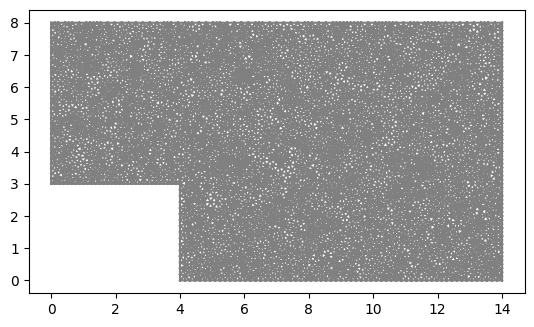

In [ ]:
# Discretization parameters
N_bulk = 64

# Define domain
L = 14.0
Wd = 8.0
L2 = 4
Wd2 = 3
geometry = Rectangle(Point(0.0, 0.0), Point(L, Wd)) - Rectangle(Point(0.0, 0.0), Point(L2, Wd2))

# Build mesh
mesh = generate_mesh(geometry, N_bulk)
plot(mesh)

In [ ]:
# Define function spaces (Taylor-Hood)
P2 = VectorElement('CG', triangle, 2)  # Velocity --> degree = 2
P1 = FiniteElement('CG', triangle, 1)  # Pressure --> degree = 1
TH = MixedElement([P2, P1])
W = FunctionSpace(mesh, TH)

In [ ]:
# Construct boundaries
bndry = MeshFunction("size_t", mesh, mesh.topology().dim()-1)

# define boundaries for the subdomain
# walls
class Walls(SubDomain):
  def inside(self, x, on_boundary):
    tol = 1E-14
    return (on_boundary and abs(x[1]) < tol) or (on_boundary and abs(x[1]- Wd) < tol) or (on_boundary and abs(x[1]- Wd2) < tol) or (on_boundary and abs(x[0]-L2) < tol)

walls = Walls()

# inflow
class Inflow(SubDomain):
  def inside(self, x, on_boundary):
    tol = 1E-14
    return on_boundary and abs(x[0]) < tol

inflow = Inflow()

# outflow
class Outflow(SubDomain):
  def inside(self, x, on_boundary):
    tol = 1E-14
    return on_boundary and abs(x[0]- L) < tol

outflow = Outflow()

bndry.set_all(0)

inflow.mark(bndry, 1)
outflow.mark(bndry, 2)
walls.mark(bndry, 3)


# Define the integration on boundary
ds = Measure("ds", domain=mesh, subdomain_data=bndry)


# Dirichlet boundary conditions
#  No-slip boundary
bc_walls = DirichletBC(W.sub(0), (0, 0), bndry, 3)
# The inflow velocity
bc_in = DirichletBC(W.sub(0), u_in, bndry, 1)
# The outflow pressure
bc_out = DirichletBC(W.sub(1), p_L, bndry, 2)

bcs = [bc_in, bc_walls, bc_in, bc_out]

In [ ]:
# Solve steady Stokes
d = 2

def epsilon(u):
    return sym(grad(u))

def sigma(u, p):
    return 2*mu*epsilon(u) - p*Identity(d)


# Define variational forms
u, p = TrialFunctions(W)
v, q = TestFunctions(W)
a = inner(sigma(u,p), epsilon(v))*dx + div(u)*q*dx
L = dot(Constant((0, 0)), v)*dx + dot(Constant((0, 0)), v)*ds

In [ ]:
# Solve the problem
w = Function(W)
solve(a == L, w, bcs)

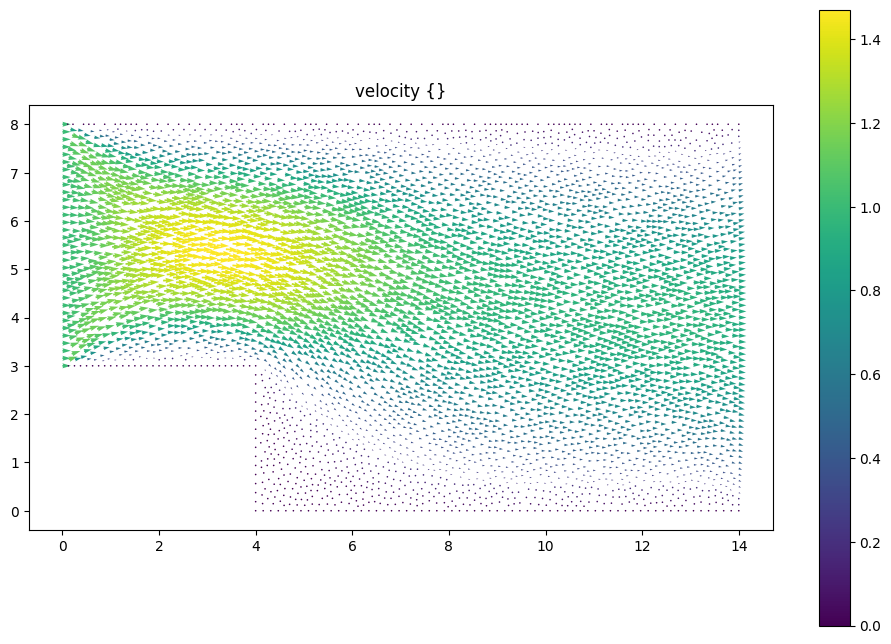

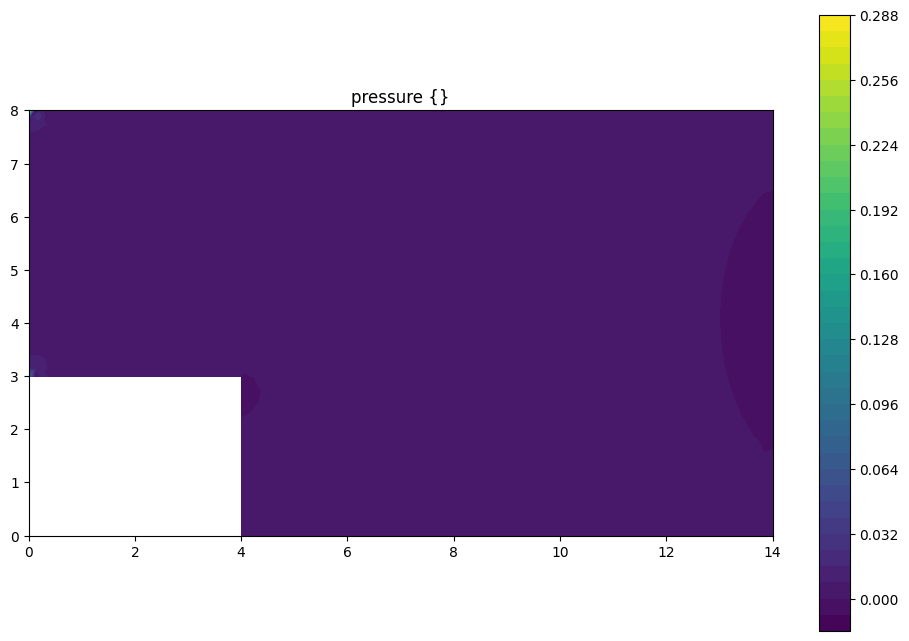

In [ ]:
u, p = w.split()
# Plot
plt.figure(figsize=(12,8))
pl = plot(u, title='velocity {}')
plt.colorbar(pl)
plt.figure(figsize=(12,8))
pl = plot(p, title='pressure {}')
plt.colorbar(pl)

In [ ]:
from dolfin import *
from mshr import *
import matplotlib.pyplot as plt


# Problem data
u_in = Expression(("0.0", "0.05"), degree=2)
p_L = Constant(0)
#u_in = Expression(('-sin(pi*x[1])', '0.0'), degree=2)
mu = Constant(1)

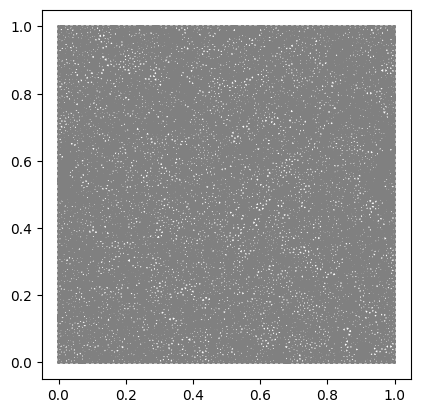

In [ ]:
# Discretization parameters
N_bulk = 64

# Define domain
L = 1
Wd = 1
geometry = Rectangle(Point(0.0, 0.0), Point(L, Wd))

# Build mesh
mesh = generate_mesh(geometry, N_bulk)
plot(mesh)

In [ ]:
# Define function spaces (Taylor-Hood)
P2 = VectorElement('CG', triangle, 2)  # Velocity --> degree = 2
P1 = FiniteElement('CG', triangle, 1)  # Pressure --> degree = 1
TH = MixedElement([P2, P1])
W = FunctionSpace(mesh, TH)

In [ ]:
# Construct boundaries
bndry = MeshFunction("size_t", mesh, mesh.topology().dim()-1)

# define boundaries for the subdomain
# walls
class Walls(SubDomain):
  def inside(self, x, on_boundary):
    tol = 1E-14
    return (on_boundary and abs(x[1]) < tol and abs(0.25 < x[0] < 1.0)) or (on_boundary and abs(x[1]- Wd) < tol and abs(0.0 < x[0] < 0.75)) or (on_boundary and abs(x[0]) < tol) or (on_boundary and abs(x[0]-L) < tol)

walls = Walls()

# inflow
class Inflow(SubDomain):
  def inside(self, x, on_boundary):
    tol = 1E-14
    return on_boundary and abs(x[1]) < tol and abs(0.0 < x[0] < 0.25)

inflow = Inflow()

# outflow
class Outflow(SubDomain):
  def inside(self, x, on_boundary):
    tol = 1E-14
    return on_boundary and abs(x[1]- Wd) < tol and abs(0.75 < x[0] < 1.0)

outflow = Outflow()

bndry.set_all(0)

inflow.mark(bndry, 1)
outflow.mark(bndry, 2)
walls.mark(bndry, 3)


# Define the integration on boundary
ds = Measure("ds", domain=mesh, subdomain_data=bndry)


# Dirichlet boundary conditions
#  No-slip boundary
bc_walls = DirichletBC(W.sub(0), (0, 0), bndry, 3)
# The inflow velocity
bc_in = DirichletBC(W.sub(0), u_in, bndry, 1)
# The outflow pressure
bc_out = DirichletBC(W.sub(1), p_L, bndry, 2)

bcs = [bc_in, bc_walls, bc_in, bc_out]

In [ ]:
# Solve steady Stokes
d = 2

def epsilon(u):
    return sym(grad(u))

def sigma(u, p):
    return 2*mu*epsilon(u) - p*Identity(d)


# Define variational forms
u, p = TrialFunctions(W)
v, q = TestFunctions(W)
a = inner(sigma(u,p), epsilon(v))*dx + div(u)*q*dx
L = dot(Constant((0, 0)), v)*dx + dot(Constant((0, 0)), v)*ds

In [ ]:
# Solve the problem
w = Function(W)
solve(a == L, w, bcs)

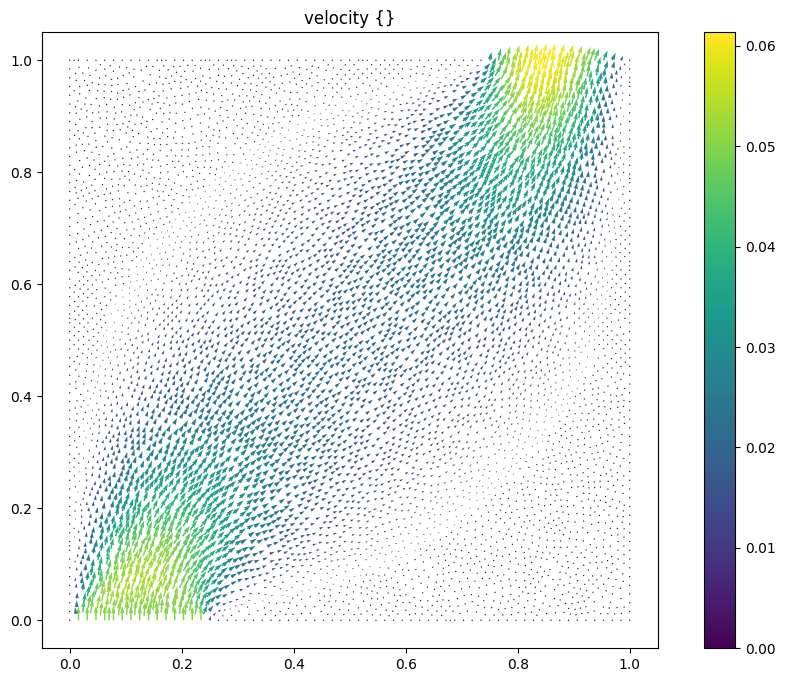

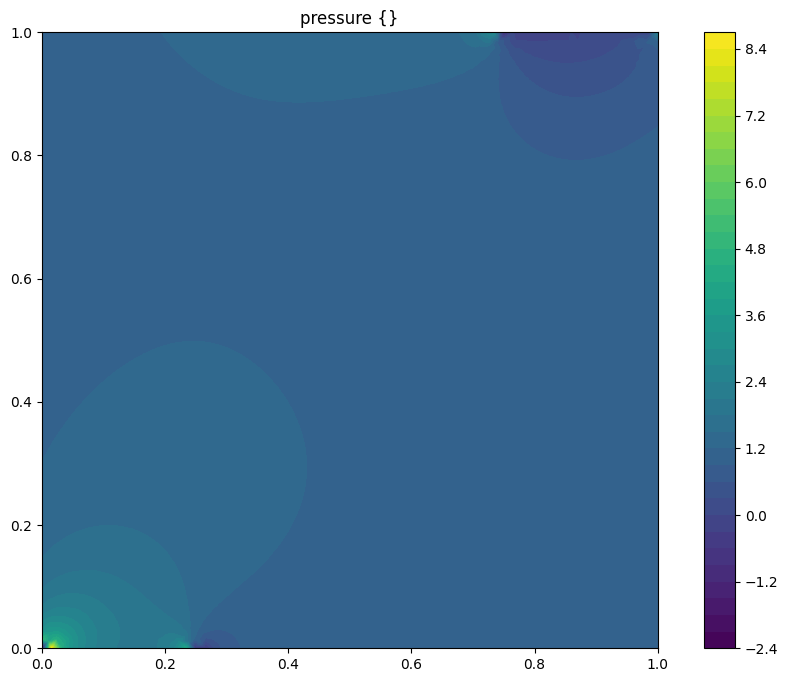

In [ ]:
u, p = w.split()
# Plot
plt.figure(figsize=(12,8))
pl = plot(u, title='velocity {}')
plt.colorbar(pl)
plt.figure(figsize=(12,8))
pl = plot(p, title='pressure {}')
plt.colorbar(pl)